# **Objective: To classify the Airline reviews into Negative, Neutral and Postive**

# Importing Packages and Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split # Split Data 
from imblearn.over_sampling import SMOTE # Handling Imbalanced

# Model Building
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics  

In [3]:
df=pd.read_csv('./drive/MyDrive/Data/Jet2 Travel/Usecase3_Dataset.csv')

In [4]:
df

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...
...,...,...,...
14635,positive,American,@AmericanAir thank you we got on a different f...
14636,negative,American,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,American,@AmericanAir Please bring American Airlines to...
14638,negative,American,"@AmericanAir you have my money, you change my ..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.2+ KB


**Observations: No Null rows present in the dataset**

# Exploratory Data Analysis


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


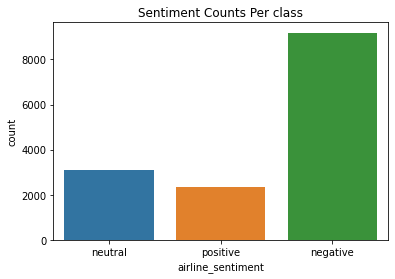

In [6]:
plt.title("Sentiment Counts Per class")
sns.countplot(df['airline_sentiment'])
plt.show()

**Observations:- The target classes are imbalanced having Major class as negative**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


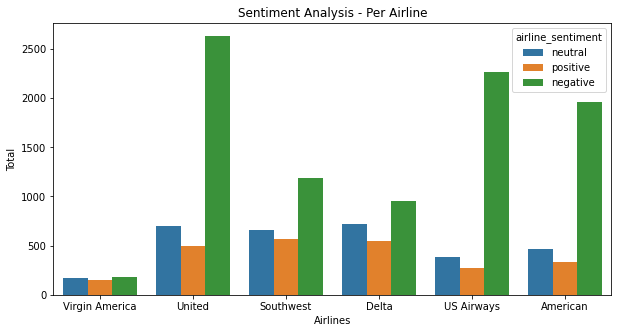

In [7]:
plt.figure(figsize=(10,5))

ax = sns.countplot(df['airline'],hue=df['airline_sentiment'])
plt.title("Sentiment Analysis - Per Airline")
plt.xlabel("Airlines")
plt.ylabel("Total")
plt.show()

In [8]:
len(df.loc[(df['airline_sentiment']=='negative') & ((df['airline']=='United') | (df['airline']=='US Airways') | (df['airline']=='American'))])/len(df.loc[df['airline_sentiment']=='negative'])

0.7470037045107867

**Note- Analyzing sentiment per airline suggests that majorly three airlines namely United,US Airways and American contribute to 74% of the Negative Reviews**


**Checking for patterns in Length as per reviews**

In [9]:
df['length of text']=df['text'].str.len()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Length distribution for Other Sentimetns')

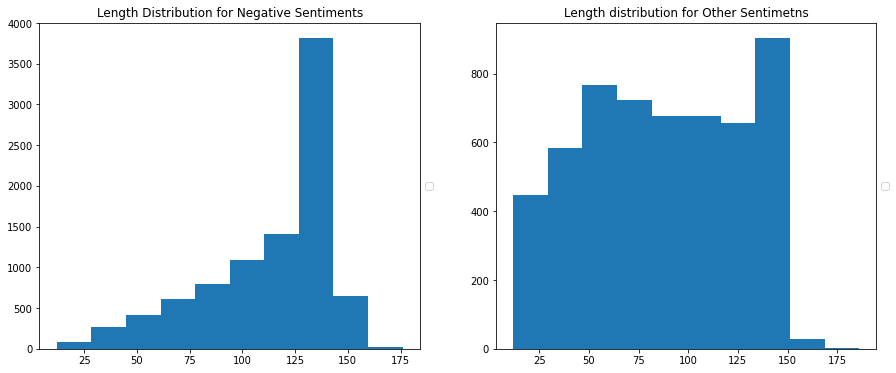

In [10]:
fig, axes = plt.subplots(1,2,figsize=(15, 6))

axes[0].hist(df.loc[df['airline_sentiment']=='negative']['length of text'])
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Length Distribution for Negative Sentiments')


plt.hist(df.loc[(df['airline_sentiment']=='positive') | (df['airline_sentiment']=='neutral')]['length of text'])
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title('Length distribution for Other Sentimetns')

**Observations - Negative sentiment reviews are usually longer**

In [11]:
ans=[]
def at_rate_words(X):
    X = X.split()
    X_new = [x for x in X if x.startswith("@") or x.startswith("@ ")]
    ans.extend(X_new)

df['text'].apply(at_rate_words)
''

''

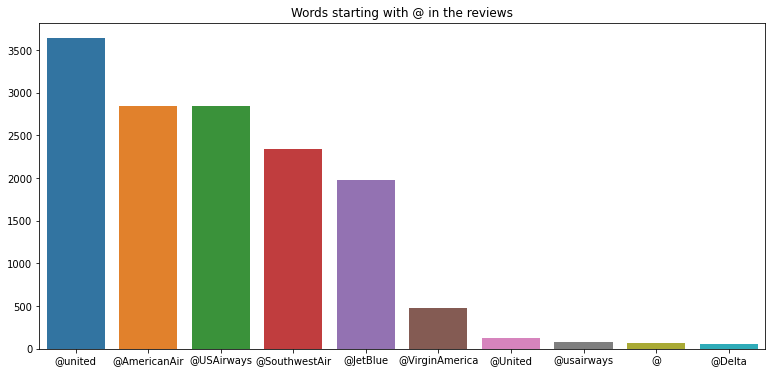

In [12]:
from collections import Counter

common_words = [word[0] for word in Counter(ans).most_common(10)]
common_counts = [word[1] for word in Counter(ans).most_common(10)]

fig = plt.figure(figsize=(13,6))
plt.title('Words starting with @ in the reviews')
sns.barplot(x=common_words, y=common_counts)
plt.show()

**Note- Most words starting with @ are airline names**

## Data Cleaning 

In [13]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
#Cleaning the sentences , removing urls,html tags, stop words and special characters
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=re.sub(r"\@\w+", "", sentence)
    sentence = re.sub(r"it's", " it is", sentence)
    sentence = re.sub(r"won\'t", " will not", sentence)
    sentence= re.sub(r"won\'t've", " will not have", sentence)
    sentence= re.sub(r"can\'t", " can not", sentence)
    sentence = re.sub(r"don\'t", " do not", sentence)
    sentence = re.sub(r"can\'t've", " can not have", sentence)
    sentence = re.sub(r"ma\'am", " madam", sentence)
    sentence = re.sub(r"let\'s", " let us", sentence)
    sentence = re.sub(r"ain\'t", " am not", sentence)
    sentence = re.sub(r"shan\'t", " shall not", sentence)
    sentence = re.sub(r"sha\n't", " shall not", sentence)
    sentence = re.sub(r"o\'clock", " of the clock", sentence)
    sentence = re.sub(r"y\'all", " you all", sentence)
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"n\'t've", " not have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'d've", " would have", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ll've", " will have", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence=sentence.replace('&amp','')
    sentence=sentence.replace('{html}'," ") 
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, ' ', sentence)
    rem_url=re.sub(r'http\S+', ' ',cleantext)
    rem_num = re.sub('[0-9]+', ' ', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]

    return " ".join(lemma_words)

df['clean_text']=df['text'].map(lambda s:preprocess(s))

In [15]:
from wordcloud import WordCloud
# world could of positive sentiments
positive = df[df['airline_sentiment'] == 'positive'].clean_text
neutral  = df[df['airline_sentiment'] == 'neutral'].clean_text
negative  = df[df['airline_sentiment'] == 'negative'].clean_text

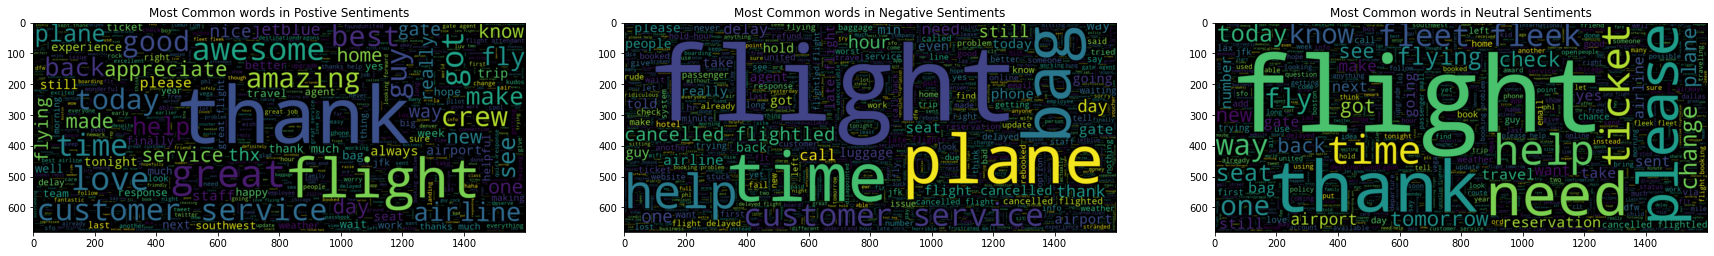

In [16]:
fig, axes = plt.subplots(1,3,figsize=(30, 30))

worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(positive))
axes[0].imshow(worldcould_pos,interpolation = 'bilinear')
axes[0].set_title('Most Common words in Postive Sentiments')

worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(negative))
axes[1].imshow(worldcould_pos,interpolation = 'bilinear')
axes[1].set_title('Most Common words in Negative Sentiments')

worldcould_pos = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 680).generate(" ".join(neutral))
axes[2].imshow(worldcould_pos,interpolation = 'bilinear')
axes[2].set_title('Most Common words in Neutral Sentiments')
plt.show()

#Preparing data for ML Training

In [17]:
x=df.drop(['airline_sentiment','text'],axis=1)

label_en=LabelEncoder()
y=label_en.fit_transform(df['airline_sentiment'])

In [18]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)

**Using Features as TF-IDF Vectors, Length of text and Airline type**

In [19]:
#Preparing Training Data

tfid = TfidfVectorizer()
minmax=MinMaxScaler()
onehot=OneHotEncoder()
airline=onehot.fit_transform(x_train[['airline']])
review=tfid.fit_transform(x_train['clean_text'])
mi=minmax.fit_transform(x_train[['length of text']])
x_train=np.c_[airline.toarray(),review.toarray(),mi]
x_train=review.toarray()

In [20]:
#Preparing Testing Data

airline_test=onehot.transform(x_test[['airline']])
review_test=tfid.transform(x_test['clean_text'])
mi_test=minmax.transform(x_test[['length of text']])
x_test=np.c_[airline_test.toarray(),review_test.toarray(),mi_test]
x_test=review_test.toarray()

In [ ]:
model1=LogisticRegression(max_iter=500)

model1.fit(x_train,y_train)
y_pred=model1.predict(x_test)
accuracy_score(y_pred,y_test)

0.773224043715847

In [ ]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2294
           1       0.65      0.43      0.52       775
           2       0.80      0.60      0.68       591

    accuracy                           0.77      3660
   macro avg       0.75      0.65      0.69      3660
weighted avg       0.76      0.77      0.76      3660

[[2145  110   39]
 [ 393  330   52]
 [ 171   65  355]]


**Since the Classes are imbalanced , Using SMOTE oversampling to Balance the classes**

In [31]:
smote = SMOTE()
x_sm,y_sm = smote.fit_resample(x_train,y_train)

# Model Training and Evaluation

**Logistic Regression model**

In [32]:
model1=LogisticRegression(max_iter=500)

model1.fit(x_sm,y_sm)

y_pred=model1.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2294
           1       0.57      0.62      0.59       775
           2       0.68      0.72      0.70       591

    accuracy                           0.77      3660
   macro avg       0.71      0.72      0.72      3660
weighted avg       0.78      0.77      0.77      3660

[[1915  288   91]
 [ 188  480  107]
 [  87   79  425]]


**Random Forest Model**

In [ ]:
model2=RandomForestClassifier()

model2.fit(x_sm,y_sm)
y_pred=model2.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      2294
           1       0.58      0.53      0.55       775
           2       0.65      0.64      0.65       591

    accuracy                           0.76      3660
   macro avg       0.69      0.68      0.68      3660
weighted avg       0.75      0.76      0.75      3660

[[1978  213  103]
 [ 269  407   99]
 [ 131   80  380]]


**Naive Bayes**

In [ ]:
model3=MultinomialNB()

model3.fit(x_sm,y_sm)
y_pred=model3.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2294
           1       0.61      0.49      0.54       775
           2       0.65      0.76      0.70       591

    accuracy                           0.77      3660
   macro avg       0.71      0.71      0.70      3660
weighted avg       0.77      0.77      0.77      3660

[[2008  173  113]
 [ 267  379  129]
 [  78   65  448]]


**Support Vector Classifier**

In [ ]:
model4=SVC()

model4.fit(x_sm,y_sm)
y_pred=model4.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.77      0.95      0.85      2294
           1       0.71      0.35      0.47       775
           2       0.79      0.59      0.68       591

    accuracy                           0.77      3660
   macro avg       0.76      0.63      0.67      3660
weighted avg       0.76      0.77      0.74      3660

[[2189   68   37]
 [ 448  274   53]
 [ 200   42  349]]


# Results

**Summary of Key Observations:**



1.   Data contains No Null values 
2.   The class distribution is imbalanced having Major class as negative.
3.   Majorly three airlines namely United,US Airways and American contribute to 74% of the Negative Reviews.
4.   Negative sentiment reviews are usually longer.
5.   Most Common Words in Positive Sentiment includes love,awesome,thank,flight,good,etc.
6.   Most Common Words in Negative Sentiment includes help,bag,cancelled,customer service,delay,etc
7.   Most Common Words in Neutral Sentiment includes  please,ticket,thank,gate,etc

**ML Model Results**

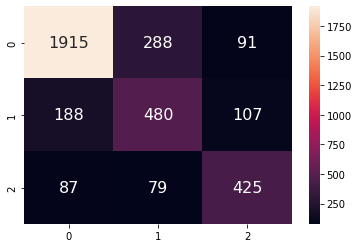

In [34]:
#Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred),fmt='d', annot=True, annot_kws={"size": 16}) 

In [33]:
#Classification Report
print(dict(zip(label_en.classes_, label_en.transform(label_en.classes_))))
print(classification_report(y_test,y_pred))

{'negative': 0, 'neutral': 1, 'positive': 2}
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2294
           1       0.57      0.62      0.59       775
           2       0.68      0.72      0.70       591

    accuracy                           0.77      3660
   macro avg       0.71      0.72      0.72      3660
weighted avg       0.78      0.77      0.77      3660



**Logistic Regression trained on SMOTE balanced data gives the best result with accuracy of 77.24% on test data.**

**With F1 Score for Negative Sentiment 0.85, Neutral Sentiment  0.59, Postive Sentiment  0.7**

